In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import os
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse.linalg import LinearOperator, cg, lsqr

import pylops
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.optimization.sparsity  import *


In [2]:
# EXPERIMENT PARAMS
from pyfrac.hydrafrac.acquisition import recgeom,rec2das_datatrnsfrm,dasgeom

# LOCATION
from pyfrac.pseudodas.receiveroperators import cubePDoperator
from pyfrac.imaging.kirchhoff import Kirchhoff
from pyfrac.utils.localisationutils import get_max_locs

# VISUALISATION
from pyfrac.visualisation.traceviz import traceimage, wiggleplot
from pyfrac.visualisation.eventimages import locimage3d

# SETUP - MODEL, REC GEOM, SOURCES

In [3]:
outpath = '../../FDModelling/homoRB_pointrecs/'
expname = 'homoRB_pointrecs'

In [4]:
# MODEL
abs_bounds = 30 # boundary points

dx = dy = dz = 0.005  # 5mm
dimlims = 0.4 
nx = ny = nz = int(dimlims/dx) 
# dimlims = nx*dx

x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz

v0 = 5260

In [5]:
# RECEIVERS
recs = np.loadtxt(os.path.join(outpath,'inputs/receiver.dat')).T
recs = recs - (abs_bounds*dx)
nr = recs.shape[1]

nt:10000, nr:384
(384, 10000)


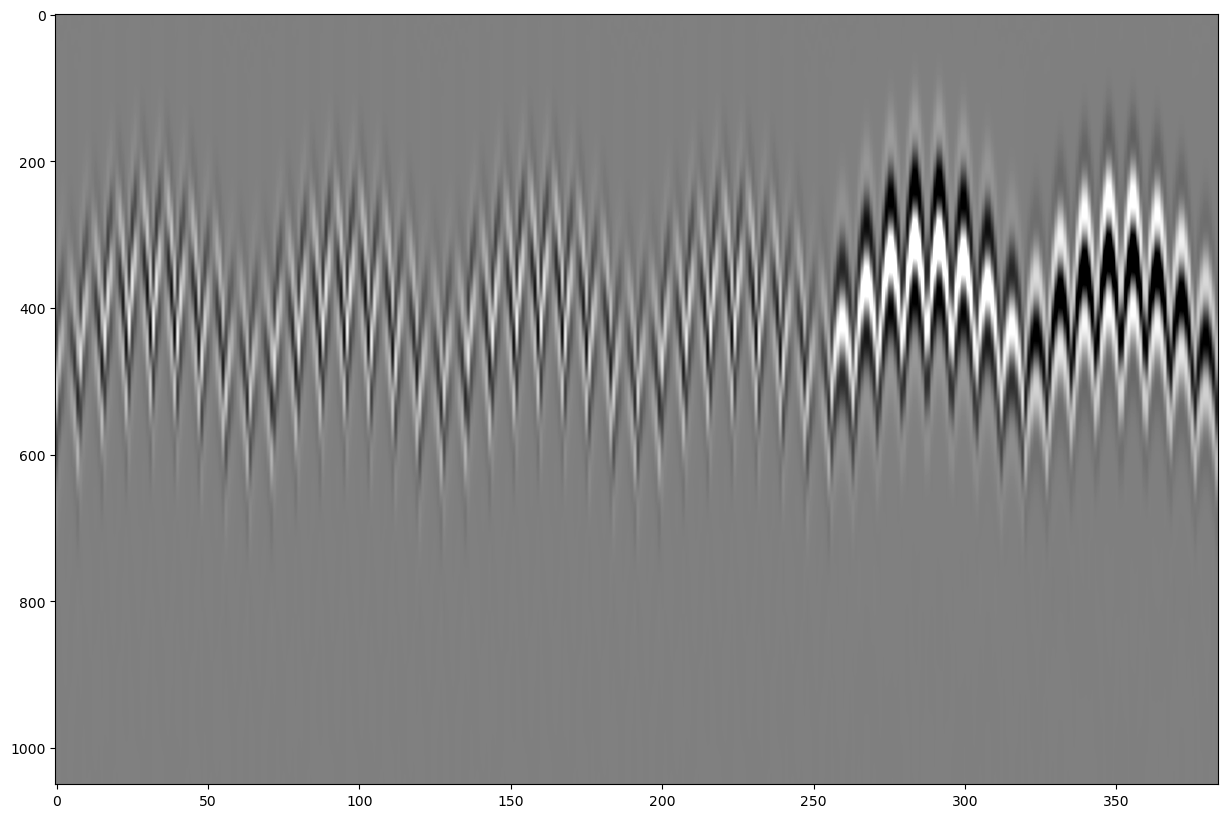

In [6]:
# SEISMIC DATA
vz_file = os.path.join(outpath,'outputs/su/%s_vz.txt'%expname)
vz_flat = np.loadtxt(vz_file,delimiter="\n")
nt = int(vz_flat.shape[0]/nr)
print('nt:%i, nr:%i'%(nt,nr))

try: 
    vz_flat.reshape((nr,nt))
except:
    print('Not good dims \n nt:%i nr:%i \n vz flat:%i'%(nt,nr,vz_flat.shape[0]))
    
vz = vz_flat[:nt*nr].reshape((nr,nt))
print(vz.shape)

tshift = 450 # index of source ignition
vz = vz[:,tshift:1500]
# Normalise each trace

seislim = np.percentile(abs(vz[:6500]),99.)
vmin=-1*seislim
vmax=seislim    
cmap='binary'              
plt.figure(figsize=[15,10])
plt.imshow(vz.T, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax, interpolation=None)



Text(0.5, 1.0, 'Point Receivers')

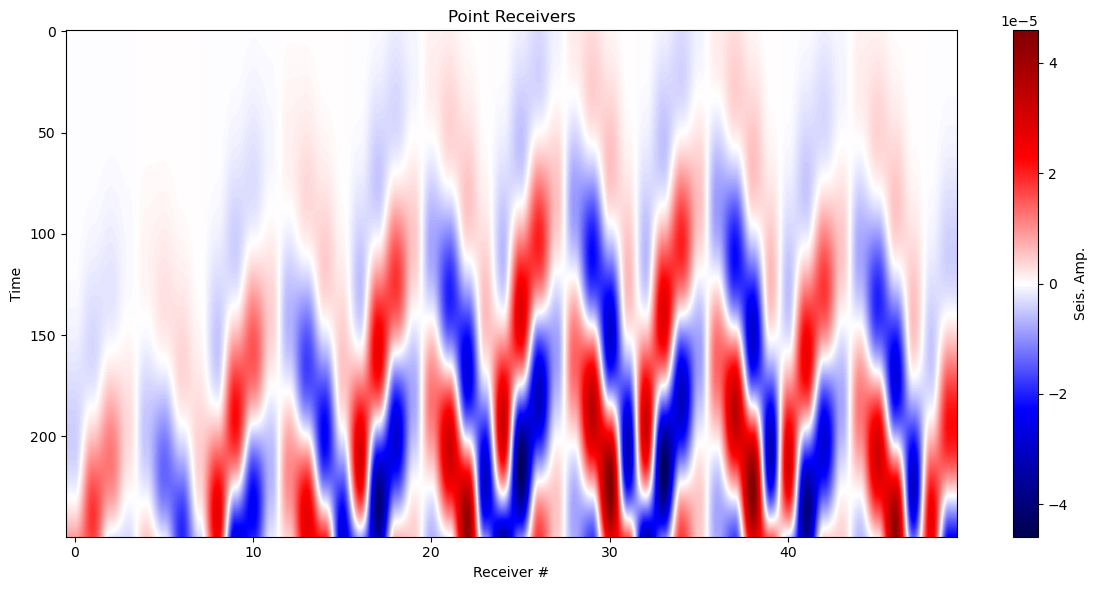

In [7]:
fig,ax = traceimage(vz[:50,150:400], climQ=99.99)
ax.set_title('Point Receivers')

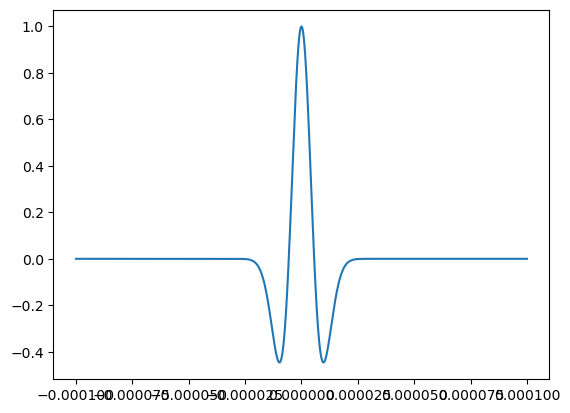

In [8]:
# TIME AXIS AND WAVELET
dt = 1e-7
nt = vz.shape[1]
t = np.arange(nt)*dt

fc = 40000
wav, wavt, wavc = ricker(t[:1000], f0=fc)
plt.plot(wavt,wav)

# Make Imaging Operator

In [9]:
# INITIALISE OPERATOR
Op = Kirchhoff(z=z, 
               x=x, 
               y=y, 
               t=t, 
               srcs=recs[:, :1], 
               recs=recs, 
               vel=v0, 
               wav=wav, 
               wavcenter=wavc, 
               mode='analytic', 
               engine='numba')

# check operator with dottest
_ = dottest(Op, verb=True)

Dot test passed, v^H(Opu)=-54244.82222204227 - u^H(Op^Hv)=-54244.82222204195


Text(0.5, 1.0, 'Point Receivers')

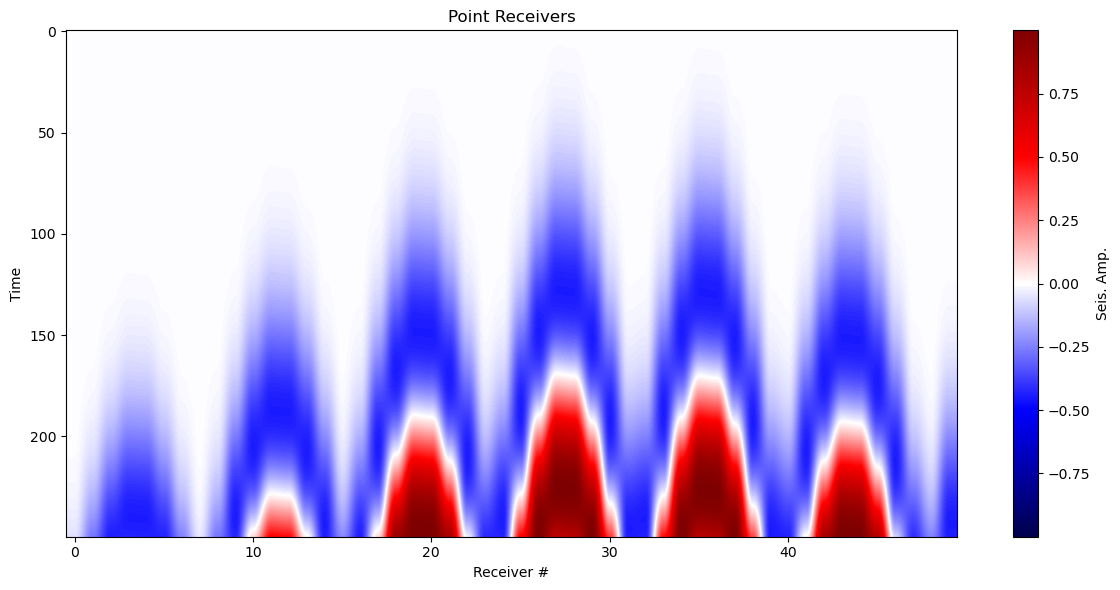

In [10]:
sx, sy, sz = [nx//2, ny//2, nz//2]
microseismic = np.zeros((nx, ny, nz))
microseismic[sx, sy, sz] = 1.

frwddata_1d = Op @ microseismic.flatten().squeeze()
frwddata  = frwddata_1d.reshape(nr,nt)
fig,ax = traceimage(frwddata[:50,150:400], climQ=99.99)
ax.set_title('Point Receivers')

# POINT REC MIGRATION

Migration-Based Hypo Center: [40.  40.  46.5]


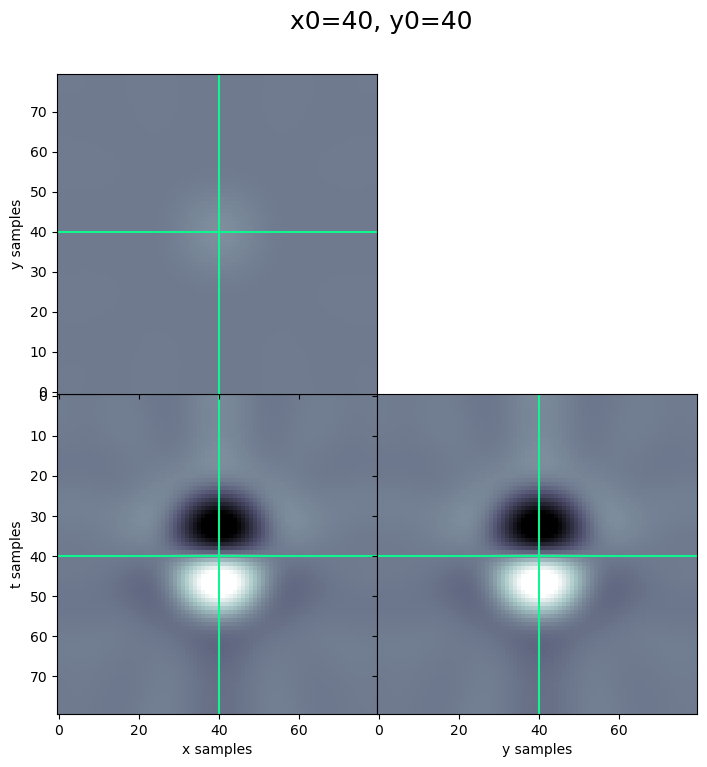

In [11]:
migrated = (Op.H @ vz).reshape(nx,ny,nz)
hc, hcs =  get_max_locs(migrated, n_max=10, rem_edge=False)
print('Migration-Based Hypo Center:',hc.flatten())
fig,axs = locimage3d(migrated,40,40)
